In [16]:
import json
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix
import medmnist
from medmnist import INFO
from IPython.display import clear_output

In [17]:
def flatten(l):
  return [item for sublist in l for item in sublist]

In [18]:

class ServerInformation:
  def __init__(self, server):
    self.config = server.config
    self.num_epochs = server.config["global_epochs"]
    self.local_accuracies = {
        client.id: client.data_frame.Accuracy.tolist() for client in server.clients
    }
    # {
    #     1 : [0.1, 0.2, ...]
    # }
    self.local_sensitivities = {
        client.id: client.data_frame.Sensitivity.tolist() for client in server.clients
    }
    self.local_specificities = {
        client.id: client.data_frame.Specificity.tolist() for client in server.clients
    }
    self.local_f1_scores = {
        client.id: client.data_frame.F1Score.tolist() for client in server.clients
    }

    self.clients_average_losses = {
        client.id: client.data_frame.Loss.tolist() for client in server.clients
    }
    self.trained = server.trained
    self.val_losses = {
        client.id: client.data_frame.ValLoss.tolist() for client in server.clients
    }
    # print(server.global_results_dict)
    self.global_accuracies = [[client['accuracy'] for client in group.values()] for group in server.global_results_dict.values()]
    self.global_specifcities = [[np.mean(client['specificity']) for client in group.values()] for group in server.global_results_dict.values()]
    self.global_sensitivities = [[np.mean(client['sensitivity']) for client in group.values()] for group in server.global_results_dict.values()]
    self.global_f1_scores = [[np.mean(client['f1_score']) for client in group.values()] for group in server.global_results_dict.values()]
    
    self.local_confusion_matrix = confusion_matrix(
        np.array(flatten([flatten(client.y) for client in server.clients])).flatten(), np.array(flatten([flatten(client.preds) for client in server.clients])).flatten()
    )
    
    # try:
    #   self.global_metrics = server.global_metrics
    # except AttributeError:
    #   self.global_metrics = {}
    #   for client in server.clients:
    #     true, pred = server.test_model_on_global_test_data(client.model)
    #     accuracy, specificity, sensitivity, f1_score = raw_values_to_metrics(true, pred, truncate=False, mean=True)
    #     self.global_metrics[client.id] = {
    #            "Accuracy": accuracy, 
    #             "Specificity": specificity,
    #             "Sensitivity": sensitivity,
    #             "F1Score": f1_score
    #         }


  def compute_average(self, evaluation_metric_name, epoch):
    # x dict
    evaluation_metric_name = evaluation_metric_name.lower()
    if evaluation_metric_name == 'accuracy':
      evaluation_metric = self.local_accuracies

    elif evaluation_metric_name == 'sensitivity':
      evaluation_metric = self.local_sensitivities

    elif evaluation_metric_name == 'specificity':
      evaluation_metric = self.local_specificities

    elif 'f1' in evaluation_metric_name:
      evaluation_metric = self.local_f1_scores

    elif 'val' in evaluation_metric_name:
      evaluation_metric = self.val_losses
      
    elif 'loss' in evaluation_metric_name:
      evaluation_metric = self.clients_average_losses
      
    else:
      print('Metric doesnt exist')
    average = 0.0
    for i in self.trained[epoch]:
      average += np.mean(evaluation_metric[i][epoch])
    return average / len(self.trained[epoch])

  def get_average(self, evaluation_metric_name):
    # x dict
    evaluation_metric_name = evaluation_metric_name.lower()
    if evaluation_metric_name == 'accuracy':
      evaluation_metric = self.local_accuracies
      title = "Local accuracy during training"
      metric = "accuracy"
    
    elif evaluation_metric_name == 'sensitivity':
      evaluation_metric = self.local_sensitivities
      title = "Local senstivities during training"
      evaluation_metric = np.array([[round_values for round_values in client_values] for client_values in np.array(list(evaluation_metric.values()))])
      metric = "sensitivity"
      ylim = (0,1.1)
    
    elif evaluation_metric_name == 'specificity':
      evaluation_metric = self.local_specificities
      title = "Local specificities during training"
      evaluation_metric = np.array([[round_values for round_values in client_values] for client_values in np.array(list(evaluation_metric.values()))])
      metric = "specificity"
      ylim = (0,1.1)
    
    elif 'f1' in evaluation_metric_name:
      evaluation_metric = self.local_f1_scores
      title = "Local f1-score during training"
      evaluation_metric = np.array([[round_values for round_values in client_values] for client_values in np.array(list(evaluation_metric.values()))])
      metric = "f1-score"

    elif 'val' in evaluation_metric_name:
      evaluation_metric = self.val_losses
      metric = "Validation Loss"

    elif 'loss' in evaluation_metric_name:
      evaluation_metric = self.clients_average_losses
      metric = "Loss"
    
    elif 'acc' in evaluation_metric_name and 'global' in evaluation_metric_name:
      evaluation_metric = self.global_accuracy
    
    else:
      print('Metric doesnt exist')
      print(evaluation_metric_name)
      return
    arr_to_return = []
    for i, trained in enumerate(self.trained):
      round_value = []
      for client in trained:
        round_value.append(evaluation_metric[client][i])
      arr_to_return.append(np.mean([np.mean(i) for i in round_value]))

    return arr_to_return

  def plot_average(self, evaluation_metric_name, std=False):
    # x dict
    evaluation_metric_name = evaluation_metric_name.lower()
    if "global" not in evaluation_metric_name:
      if evaluation_metric_name == 'accuracy':
        evaluation_metric = self.local_accuracies
        title = "Local accuracy during training"
        metric = "accuracy"

      elif evaluation_metric_name == 'sensitivity':
        evaluation_metric = self.local_sensitivities
        title = "Local senstivities during training"
        evaluation_metric = np.array([[np.mean(round_values) for round_values in client_values] for client_values in np.array(list(evaluation_metric.values()))])
        metric = "sensitivity"
        ylim = (0,1.1)

      elif evaluation_metric_name == 'specificity':
        evaluation_metric = self.local_specificities
        title = "Local specificities during training"
        evaluation_metric = np.array([[np.mean(round_values) for round_values in client_values] for client_values in np.array(list(evaluation_metric.values()))])
        metric = "specificity"
        ylim = (0,1.1)

      elif 'f1' in evaluation_metric_name:
        evaluation_metric = self.local_f1_scores
        title = "Local f1-score during training"
        evaluation_metric = np.array([[np.mean(round_values) for round_values in client_values] for client_values in np.array(list(evaluation_metric.values()))])
        metric = "f1-score"
        ylim = (0,1.1)

      elif 'val' in evaluation_metric_name:
        evaluation_metric = self.val_losses
        title = "Local validation loss during training"
        metric = "Validation Loss"

      elif 'loss' in evaluation_metric_name:
        evaluation_metric = self.clients_average_losses
        title = "Average Loss during training"
        metric = "Loss"
    elif "global" in evaluation_metric_name:
        if 'acc' in evaluation_metric_name:
          evaluation_metric = self.global_accuracies
          title = "Global accuracy during training"
          ylabel = "Accuracy"
        elif 'speci' in evaluation_metric_name:
          evaluation_metric = self.global_specifcities
          title = "Global specificity during training"
          ylabel = "Specificity"
          ylim = (0, 1.1)
        elif 'sensit' in evaluation_metric_name:
          evaluation_metric = self.global_sensitivities
          title = "Global sensitivity during training"
          ylabel = "Sensitivity"
          ylim = (0, 1.1)
        elif 'f1' in evaluation_metric_name:
          evaluation_metric = self.global_f1_scores
          title = "Global f1-scores during training"
          ylabel = "f1-scores"
          ylim = (0, 1.1)
        else:
          print(f'Metric {evaluation_metric_name} doesnt exist')
          return
        
        if std:
          print("we only have the average values, no std ")
        evaluation_metric = np.array(evaluation_metric).mean(axis=0)
        print(np.array(evaluation_metric).shape)
        fig = plt.figure()
        plt.figure(figsize=(10,8))
        plt.plot(list(range(len(evaluation_metric))), evaluation_metric, label=title)
        plt.title(title)
        plt.xlabel("Training Epochs")
        plt.ylabel(ylabel)
        # Add a grid with custom colors
        plt.grid(True, color='gray', linestyle='dashed', linewidth=0.5)
        plt.legend()
        ax = plt.gca()
        ax.set_facecolor((0,0,0,0.05))
        ax.set_xticks(list(range(0,len(evaluation_metric), len(evaluation_metric) // 4)))
        try:
          plt.ylim(*ylim)
        except NameError:
          pass
        plt.xlim(0, len(evaluation_metric)-1)
        plt.show()
        return
    else:
      print(f'Metric {evaluation_metric_name} doesnt exist')
      return
    # evaluation_metric = np.array(list(evaluation_metric.values()))
    arr_to_plot = []
    if std:
      std_values = []
    for i, trained in enumerate(self.trained):
      round_value = []
      for client in trained:
        round_value.append(evaluation_metric[client][i])
      if std:
        std_values.append(np.std(round_value))
      arr_to_plot.append(np.mean(round_value))
    
    if std:
      std_values = np.array(std_values)
      upper = arr_to_plot + std_values
      lower = arr_to_plot - std_values
    
    fig = plt.figure()
    plt.figure(figsize=(10,8))
    plt.plot(list(range(len(arr_to_plot))), arr_to_plot, label=title)
    if std:
      plt.fill_between(list(range(len(arr_to_plot))),upper, lower, color="C0", alpha=0.3, label="std of "+ title)
    plt.title(title)
    plt.xlabel("Training Epochs")
    plt.ylabel(metric)
    # Add a grid with custom colors
    plt.grid(True, color='gray', linestyle='dashed', linewidth=0.5)
    plt.legend()
    ax = plt.gca()
    ax.set_facecolor((0,0,0,0.05))
    ax.set_xticks(list(range(0,len(arr_to_plot), len(arr_to_plot) // 4)))
    if std:
      plt.ylim(0, max(upper)+0.1)
    else:
      try:
        plt.ylim(*ylim)
      except NameError:
        pass
    plt.xlim(0, len(arr_to_plot)-1)
    plt.show()

  def plot_local_confusion_matrix(self):
    plt.figure(figsize=(10,8))
    sns.heatmap(self.local_confusion_matrix, cmap="YlGnBu", fmt=".2f")
    plt.title("Local test set Confusion matrix")
    plt.xlabel("Labels")
    plt.ylabel("Labels")
    plt.show()

  def summary_dict(self):
    return {
          "local_accuracies": self.get_average('accuracy'),
          "local_sensitivities": self.get_average('sensitivity'),
          "local_specificities": self.get_average('specificity'),
          "local_f1_scores": self.get_average('f1'),
          "local_val_losses": self.get_average('val'),
          "clients_average_losses": self.get_average('loss'),
          "global_accuracies": self.global_accuracies,
          "global_specifcities": self.global_specifcities,
          "global_sensitivities": self.global_sensitivities,
          "global_f1_scores": self.global_f1_scores
        }

  def __repr__(self):
    return str(self.summary_dict())


In [19]:
with open("./Seq_Clusterd_FL_0_3participation_200Epochs_fold_1_SI.pkl" , "rb") as f:
    _03_200EPOCHS_SI = pkl.load(f)

with open("./Seq_Clusterd_FL_0_7participation_200Epochs_fold_1_SI.pkl" , "rb") as f:
    _07_200EPOCHS_SI = pkl.load(f)

with open("./Seq_Clusterd_FL_1_0participation_200Epochs_fold_1_SI.pkl" , "rb") as f:
    _10_200EPOCHS_SI = pkl.load(f)

with open("./Seq_Clusterd_FL_0_3participation_50Epochs_fold_1__with_server_SI.pkl", "rb") as f:
    _03_50EPOCHS_SI = pkl.load(f)

with open("./0_3_Clustered_FL_WithServer_SI.pkl", "rb") as f:
    _03_200EPOCHS_withserver_SI = pkl.load(f)

with open("./0_7_Clustered_FL_WithServer_SI.pkl", "rb") as f:
    _07_200EPOCHS_withserver_SI = pkl.load(f)

with open("./1_Seq_Clustered_FL_WithServer_SI.pkl", "rb") as f:
    _10_200EPOCHS_withserver_SI = pkl.load(f)

with open("./0_3_ordered_Seq_FL__SI.pkl", "rb") as f:
    ordered = pkl.load(f)


In [20]:
_03_200EPOCHS_local_acc = _03_200EPOCHS_SI.get_average("accuracy")
_07_200EPOCHS_local_acc = _07_200EPOCHS_SI.get_average("accuracy")
_10_200EPOCHS_local_acc = _10_200EPOCHS_SI.get_average("accuracy")
_03_50EPOCHS_local_acc = _03_50EPOCHS_SI.get_average("accuracy")
_03_200EPOCHS_withserver_local_acc = _03_200EPOCHS_withserver_SI.get_average("accuracy")
_07_200EPOCHS_withserver_local_acc = _07_200EPOCHS_withserver_SI.get_average("accuracy")
_10_200EPOCHS_withserver_local_acc = _10_200EPOCHS_withserver_SI.get_average("accuracy")
_03_200EPOCHS_withserver_local_acc_final = _03_200EPOCHS_withserver_local_acc[-1]
_07_200EPOCHS_withserver_local_acc_final = _07_200EPOCHS_withserver_local_acc[-1]
_10_200EPOCHS_withserver_local_acc_final = _10_200EPOCHS_withserver_local_acc[-1]
_03_200EPOCHS_local_acc_final = _03_200EPOCHS_local_acc[-1]
_07_200EPOCHS_local_acc_final = _07_200EPOCHS_local_acc[-1]
_10_200EPOCHS_local_acc_final = _10_200EPOCHS_local_acc[-1]

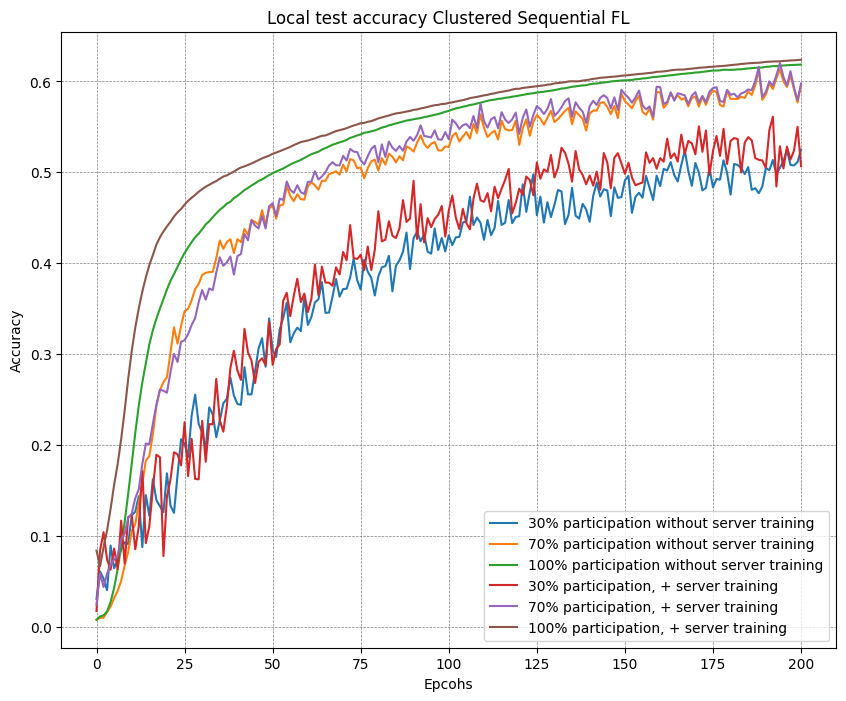

In [21]:
plt.figure(figsize=(10,8))
plt.plot(_03_200EPOCHS_local_acc, label="30% participation without server training")
plt.plot(_07_200EPOCHS_local_acc, label="70% participation without server training")
plt.plot(_10_200EPOCHS_local_acc, label="100% participation without server training")
plt.plot(_03_200EPOCHS_withserver_local_acc, label="30% participation, + server training")
plt.plot(_07_200EPOCHS_withserver_local_acc, label="70% participation, + server training")
plt.plot(_10_200EPOCHS_withserver_local_acc, label="100% participation, + server training")
plt.title("Local test accuracy Clustered Sequential FL")
plt.xlabel("Epcohs")
plt.ylabel("Accuracy")
plt.grid(True, color='gray', linestyle='dashed', linewidth=0.5)
plt.legend()

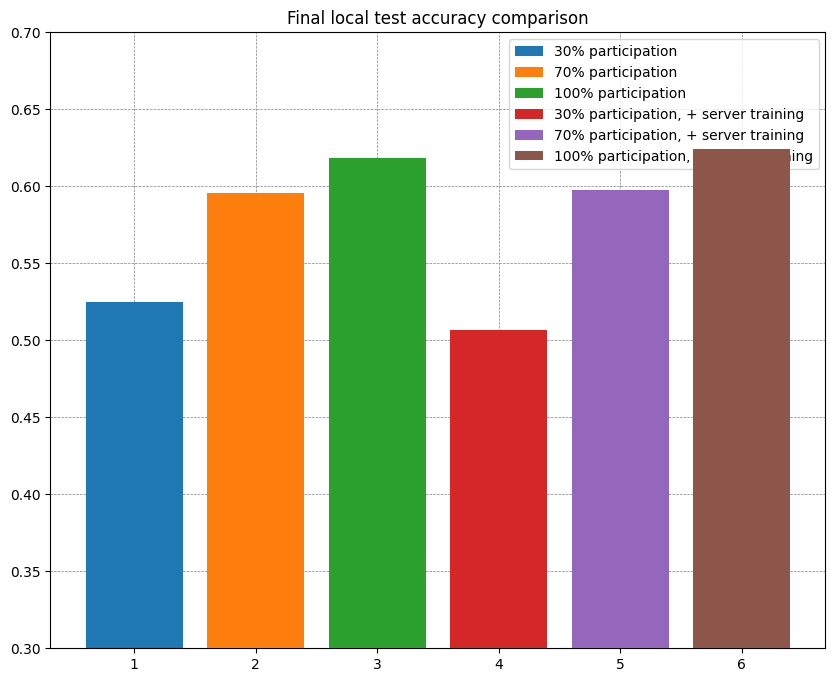

In [22]:
plt.figure(figsize=(10,8))
plt.bar(["1"], [_03_200EPOCHS_local_acc[-1]], label="30% participation", zorder=1+1)
plt.bar(["2"], [_07_200EPOCHS_local_acc[-1]], label="70% participation", zorder=2+1)
plt.bar(["3"], [_10_200EPOCHS_local_acc[-1]], label="100% participation", zorder=3+1)
plt.bar(["4"], [_03_200EPOCHS_withserver_local_acc[-1]], label="30% participation, + server training", zorder=4+1)
plt.bar(["5"], [_07_200EPOCHS_withserver_local_acc[-1]], label="70% participation, + server training", zorder=5+1)
plt.bar(["6"], [_10_200EPOCHS_withserver_local_acc[-1]], label="100% participation, + server training", zorder=6+1)
plt.grid(True, color='gray', linestyle='dashed', linewidth=0.5, zorder=1)
plt.ylim(0.3, 0.7)
plt.legend()
plt.title("Final local test accuracy comparison")
plt.show()

In [23]:
_03_200EPOCHS_global_acc = np.array(_03_200EPOCHS_SI.global_accuracies).mean(axis=1)
_07_200EPOCHS_global_acc = np.array(_07_200EPOCHS_SI.global_accuracies).mean(axis=1)
_10_200EPOCHS_global_acc = np.array(_10_200EPOCHS_SI.global_accuracies).mean(axis=1)
_03_200EPOCHS_withserver_global_acc = np.array(_03_200EPOCHS_withserver_SI.global_accuracies).mean(axis=1)
_07_200EPOCHS_withserver_global_acc = np.array(_07_200EPOCHS_withserver_SI.global_accuracies).mean(axis=1)
_10_200EPOCHS_withserver_global_acc = np.array(_10_200EPOCHS_withserver_SI.global_accuracies).mean(axis=1)
_03_200EPOCHS_withserver_local_acc_final = _03_200EPOCHS_withserver_local_acc[-1]
_07_200EPOCHS_withserver_local_acc_final = _07_200EPOCHS_withserver_local_acc[-1]
_10_200EPOCHS_withserver_local_acc_final = _10_200EPOCHS_withserver_local_acc[-1]
_03_200EPOCHS_local_acc_final = _03_200EPOCHS_local_acc[-1]
_07_200EPOCHS_local_acc_final = _07_200EPOCHS_local_acc[-1]
_10_200EPOCHS_local_acc_final = _10_200EPOCHS_local_acc[-1]
# _03_50EPOCHS_global_acc = _03_50EPOCHS_SI.get_average("accuracy")

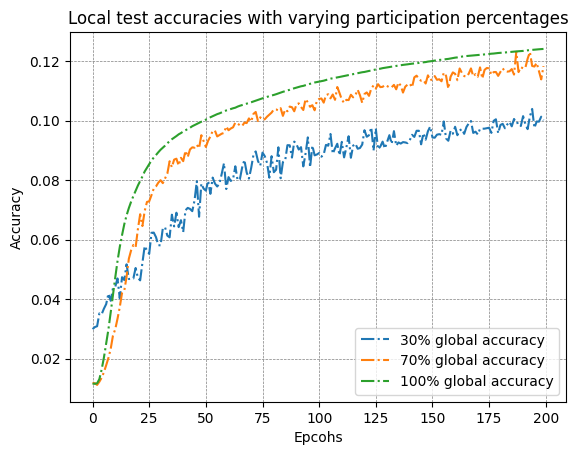

In [24]:
plt.plot(np.array(_03_200EPOCHS_SI.global_accuracies).mean(axis=1), label="30% global accuracy", linestyle='-.')
plt.plot(np.array(_07_200EPOCHS_SI.global_accuracies).mean(axis=1), label="70% global accuracy", linestyle='-.')
plt.plot(np.array(_10_200EPOCHS_SI.global_accuracies).mean(axis=1), label="100% global accuracy", linestyle='-.')
plt.title("Local test accuracies with varying participation percentages")
plt.xlabel("Epcohs")
plt.ylabel("Accuracy")
plt.grid(True, color='gray', linestyle='dashed', linewidth=0.5)
plt.legend()

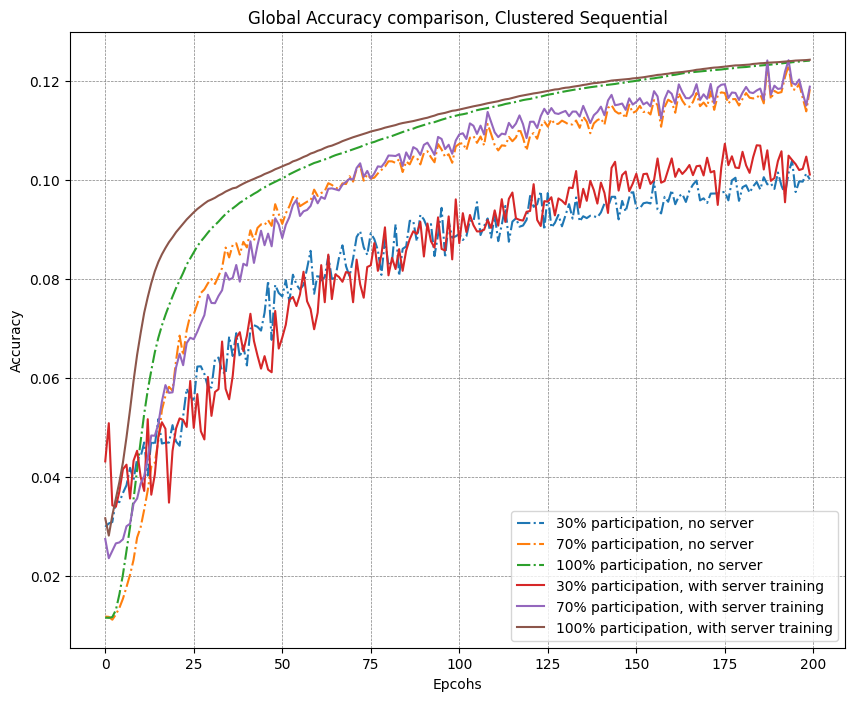

In [25]:
plt.figure(figsize=(10, 8))
plt.plot(_03_200EPOCHS_global_acc, label="30% participation, no server", linestyle="-.")
plt.plot(_07_200EPOCHS_global_acc, label="70% participation, no server", linestyle="-.")
plt.plot(_10_200EPOCHS_global_acc, label="100% participation, no server", linestyle="-.")
plt.plot(_03_200EPOCHS_withserver_global_acc, label="30% participation, with server training")
plt.plot(_07_200EPOCHS_withserver_global_acc, label="70% participation, with server training")
plt.plot(_10_200EPOCHS_withserver_global_acc, label="100% participation, with server training")
plt.legend()
plt.xlabel("Epcohs")
plt.ylabel("Accuracy")
plt.grid(True, color='gray', linestyle='dashed', linewidth=0.5)
plt.title("Global Accuracy comparison, Clustered Sequential")
plt.savefig("./global_acc_comparison_clusterd.png")
plt.show()

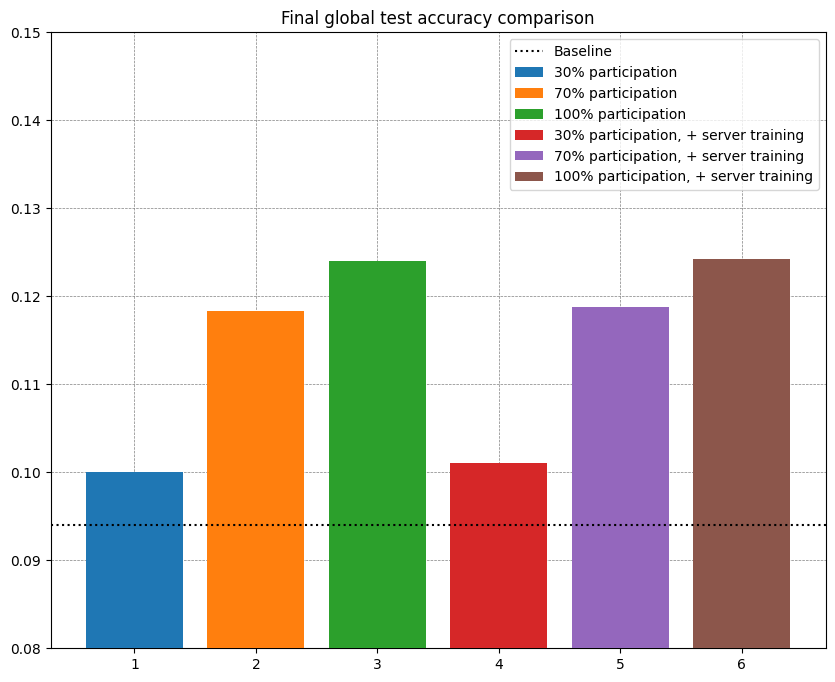

In [26]:
plt.figure(figsize=(10,8))
plt.bar(["1"], [_03_200EPOCHS_global_acc[-1]], label="30% participation", zorder=1+2)
plt.bar(["2"], [_07_200EPOCHS_global_acc[-1]], label="70% participation", zorder=2+2)
plt.bar(["3"], [_10_200EPOCHS_global_acc[-1]], label="100% participation", zorder=3+2)
plt.bar(["4"], [_03_200EPOCHS_withserver_global_acc[-1]], label="30% participation, + server training", zorder=4+2)
plt.bar(["5"], [_07_200EPOCHS_withserver_global_acc[-1]], label="70% participation, + server training", zorder=5+2)
plt.bar(["6"], [_10_200EPOCHS_withserver_global_acc[-1]], label="100% participation, + server training", zorder=6+2)
plt.grid(True, color='gray', linestyle='dashed', linewidth=0.5, zorder=1)
plt.ylim(0.08, 0.15)
plt.title("Final global test accuracy comparison")
plt.axhline(0.094, color="black", zorder=10, label="Baseline", linestyle="dotted")
plt.legend()
plt.show()

In [27]:

print()
print([_03_200EPOCHS_global_acc[-1]])
print([_07_200EPOCHS_global_acc[-1]])
print([_10_200EPOCHS_global_acc[-1]])
print([_03_200EPOCHS_withserver_global_acc[-1]])
print([_07_200EPOCHS_withserver_global_acc[-1]])
print([_10_200EPOCHS_withserver_global_acc[-1]])


[0.10008723927353476]
[0.11828285918221677]
[0.12405424696645254]
[0.10107066381156318]
[0.11879949695795522]
[0.12423982869379013]


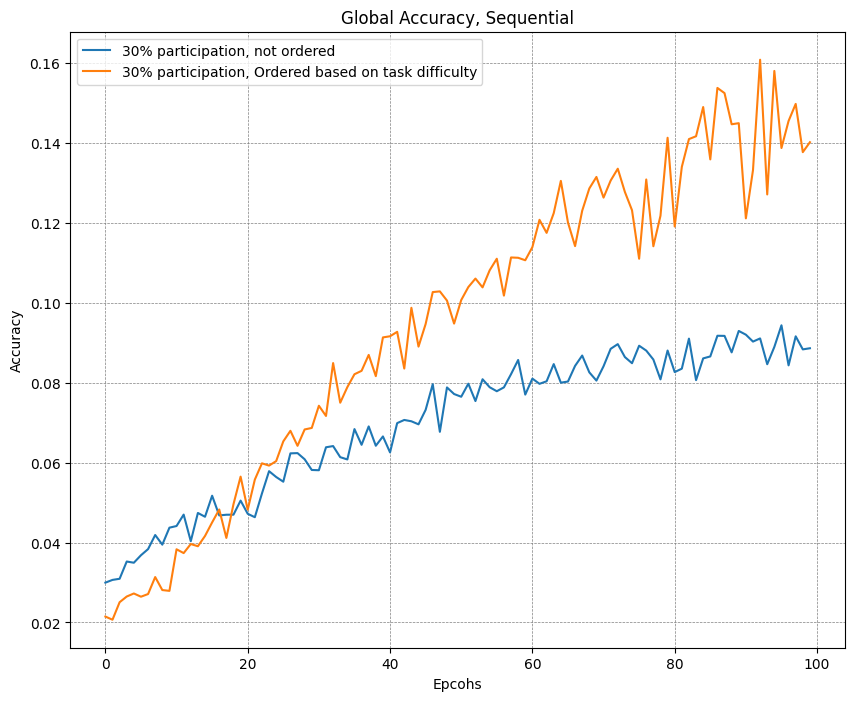

In [28]:
plt.figure(figsize=(10, 8))
plt.plot(_03_200EPOCHS_global_acc[:100], label="30% participation, not ordered")
plt.plot(np.array(ordered.global_accuracies).mean(axis=1), label="30% participation, Ordered based on task difficulty")
plt.legend()
plt.xlabel("Epcohs")
plt.ylabel("Accuracy")
plt.grid(True, color='gray', linestyle='dashed', linewidth=0.5)
plt.title("Global Accuracy, Sequential")
plt.show()

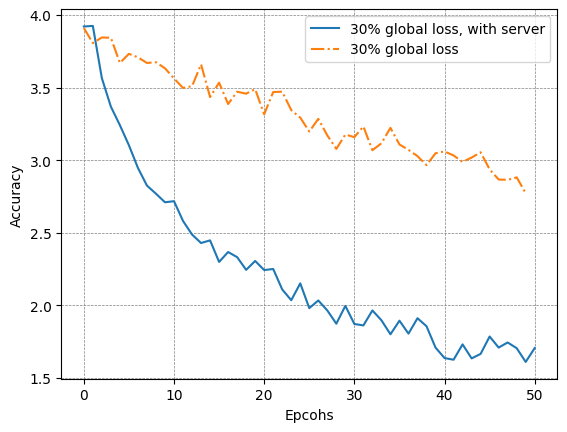

In [29]:
plt.plot(np.array(_03_50EPOCHS_SI.get_average("global loss")), label="30% global loss, with server", linestyle='solid')
plt.plot(np.array(_03_200EPOCHS_SI.get_average("global loss"))[:50], label="30% global loss", linestyle='-.')
plt.xlabel("Epcohs")
plt.ylabel("Accuracy")
plt.grid(True, color='gray', linestyle='dashed', linewidth=0.5)
plt.legend()

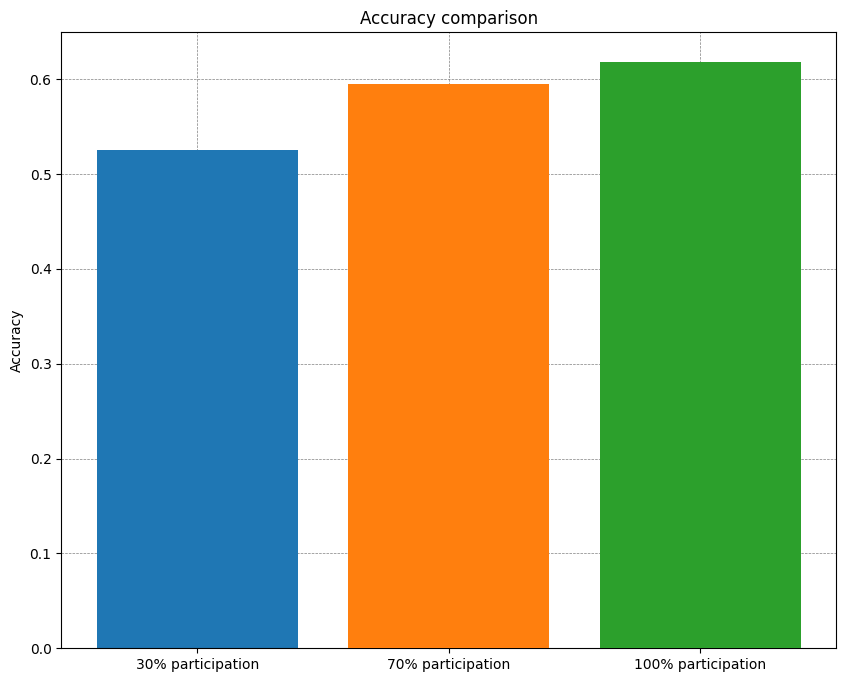

In [30]:
plt.figure(figsize=(10,8))
plt.grid(color='gray', linestyle='dashed', linewidth=0.5, zorder=0)
plt.bar(["30% participation"],[_03_200EPOCHS_local_acc_final], zorder=2)
plt.bar(["70% participation"],[_07_200EPOCHS_local_acc_final], zorder=3)
plt.bar(["100% participation"],[_10_200EPOCHS_local_acc_final], zorder=4)
plt.title("Accuracy comparison")
plt.ylabel("Accuracy")
plt.show()

# Final PLots 

In [56]:
import copy

In [ ]:
Local epochs: 5/ server: 10 / participation: 30%/ reordering : yes + decreasing lr for first iteration only / lr after : 0.00001  (RUNNING) hazem colab 6


# Pickles

Ordered 1 local epoch, 10 server lr 0.00001, 30% participation + dropout

In [209]:
with open("Ordered_1localepoch_5server_epochs_at_each_global_round_lr_ 0.01_server_avg__30_participation_SeqFL+dropout_layer.pkl", "rb") as f:
    Ordered_1localepoch_5server_epochs_at_each_global_round_lr_0_01_server_avg__30_participation_SeqFL_dropout_layer = pkl.load(f)
with open("Ordered_1localepoch_10server_epochs_at_each_global_round_lr_ 0.00001_server_avg__30_participation_SeqFL.pkl", "rb") as f:
    Ordered_1localepoch_10server_epochs_at_each_global_round_lr__0_00001_server_avg__30_participation_SeqFL_pkl = pkl.load(f)
with open("Ordered_1localepoch_10server_epochs_at_each_global_round_lr_ 0.00001_server_avg__30_participation_SeqFL+dropout_layer.pkl", 'rb') as f:
    Ordered_1localepoch_10server_epochs_at_each_global_round_lr__0_00001_server_avg__30_participation_SeqFL_dropout_layer_pkl = pkl.load(f)
with open("clustered_0_3participation_5_local_10_server_lr_changes_first_time.pkl", 'rb') as f:
    clustered_0_3participation_5_local_10_server_lr_changes_first_time = pkl.load(f)
with open("fedavg_0_00001lr_30%participation_150rounds_10global_1server.pkl", 'rb') as f:
    fedavg_0_00001lr_30_participation_150rounds_10global_1server = pkl.load(f)
with open("fedprox_mu0_001_lr_0_00001_30participation_150rounds_10server_1local.pkl", 'rb') as f:
    fedprox_mu0_001_lr_0_00001_30participation_150rounds_10server_1local = pkl.load(f)
with open("ordered_1_local_epoch_5_server_lr_0.01_50%_participation_dropout.pkl", 'rb') as f:
    ordered_1_local_epoch_5_server_lr_0_01_50__participation_dropout = pkl.load(f)
with open("ordered_5local_10server_0_00001_30partiipation.pkl", 'rb') as f:
    ordered_5local_10server_0_00001_30partiipation = pkl.load(f)
# Yass  
with open("organa_oct_clustered_FL_5LE_200GE_noservertraining_0_00001LR30participation.pkl", 'rb') as f:
    organa_oct_clustered_FL_5LE_200GE_noservertraining_0_00001LR30participation = pkl.load(f)
with open("nopathmnist_Localepochs5_server_10_participation_30reordering_decreasinglronce_lrafter00001.pkl", 'rb') as f:
    nopathmnist_Localepochs5_server_10_participation_30reordering_decreasinglronce_lrafter00001 = pkl.load(f)
with open("oct_organa_ocalepochs5_server_10_par30_reordering_decreasinglronce_lrafter00001.pkl", 'rb') as f:
    oct_organa_ocalepochs5_server_10_par30_reordering_decreasinglronce_lrafter00001 = pkl.load(f)
with open("ordered_5local_10server_0_00001_30partiipation.pkl", 'rb') as f:
    ordered_5local_10server_0_00001_30partiipation = pkl.load(f)
with open("Localepochs1_server10_par30_reordering_decreasinglronce_lrafter000001.pkl", 'rb') as f:
    Localepochs1_server10_par30_reordering_decreasinglronce_lrafter000001 = pkl.load(f)
with open("ordered_5local_10server_lr_0_00001_50participation.pkl", 'rb') as f:
    ordered_5local_10server_lr_0_00001_50participation = pkl.load(f)

In [210]:
colors = {
    "blue": (0.0, 0.4470588235294118, 0.6980392156862745),   # Blue
    "orange": (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),   # Orange
    "red": (0.8, 0.15294117647058825, 0.1568627450980392),   # Red
    "purple": (0.5803921568627451, 0.403921568627451, 0.7411764705882353),   # Purple
    "brown": (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),   # Brown
    "pink": (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),   # Pink
    "gray": (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),   # Gray
    "yellow": (0.9294117647058824, 0.6941176470588235, 0.12549019607843137),   # Yellow
    "green": (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),   # Green
}

In [211]:
def global_accuracies_dict_gen(global_accuracies_dictionary, average=False):
    results = {ds: [] for ds in names}
    for result in global_accuracies_dictionary.values():
        for ds in names:
            results[ds].append(
                np.mean([
                    client[ds] for client in result
                ])
            )
    if average:
        results = np.mean(list(results.values()), axis=0)
    return results

In [212]:
def get_average_loss(si):
    trained = si.trained
    result = []
    for i, group in enumerate(trained):
        result.append([])
        for client in group:
            result[-1].append(si.clients_average_losses[client][i+1])
        result[-1] = np.mean(result[-1])
    return result

In [213]:
def get_average_global_accuracy_with_no_dict(si):
    return np.mean(si.global_accuracies, axis=1)

# Colab 6 (clustered) / Hamza (Sequential)

In [214]:
hamza = copy.deepcopy(ordered_5local_10server_0_00001_30partiipation)
colab_6 = copy.deepcopy(clustered_0_3participation_5_local_10_server_lr_changes_first_time)

In [215]:
names = ["organamnist", "octmnist", "bloodmnist", "pathmnist", "tissuemnist"]

## Accuracy

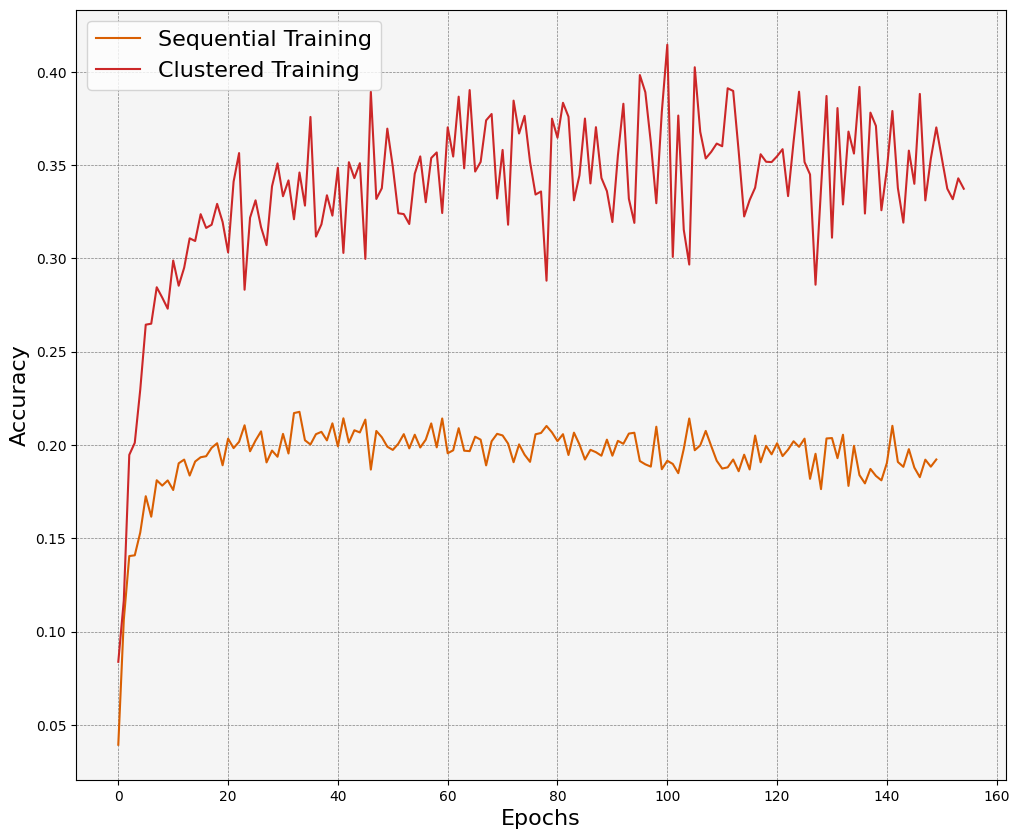

In [216]:
hamza_global_acc = global_accuracies_dict_gen(hamza.global_accuracies_dict, True)
colab_6_global_acc = global_accuracies_dict_gen(colab_6.global_accuracies_dict, True)
fig , ax = plt.subplots(figsize=(12, 10))
ax.set_facecolor((0.96, 0.96, 0.96))
ax.grid(True, color='gray', linestyle='dashed', linewidth=0.5)
ax.plot(hamza_global_acc, label="Sequential Training", color=colors["orange"])
ax.plot(colab_6_global_acc, label="Clustered Training", color=colors["red"])
ax.set_xlabel("Epochs", fontsize=16)
ax.set_ylabel("Accuracy", fontsize=16)
ax.legend(fontsize=16)

## Loss

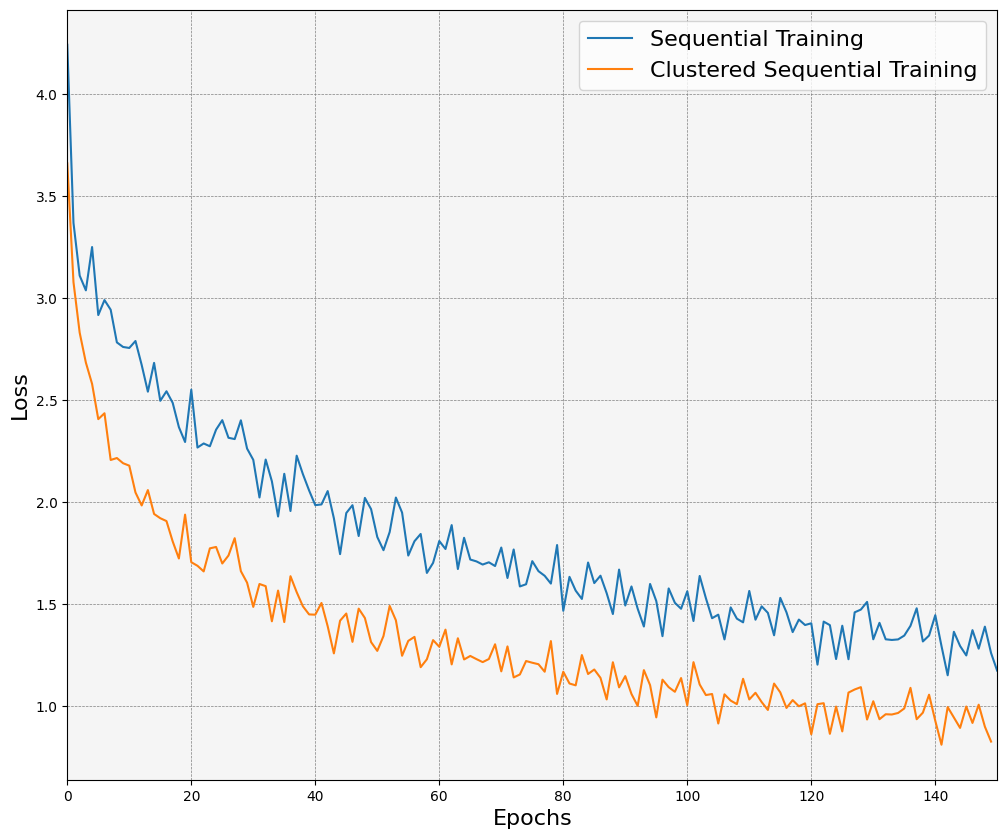

In [243]:
fig , ax = plt.subplots(figsize=(12, 10))
ax.set_facecolor((0.96, 0.96, 0.96))
ax.grid(True, color='gray', linestyle='dashed', linewidth=0.5)
ax.plot(colab_6.get_average("global loss"), label="Sequential Training")
ax.plot(get_average_loss(hamza), label="Clustered Sequential Training")
ax.set_xlabel("Epochs", fontsize=16)
ax.set_ylabel("Loss", fontsize=16)
ax.set_xlim(0, 150)
ax.legend(fontsize=16)
plt.show()

# Sequential

## Participation: Ordered 1 local epoch 5 server lr 0.01 30% participation (100 global) vs hazem colab 5: (Ordered 1 local epoch, 5 server lr 0.01, 50% participation)

In [218]:
colab_5 = copy.deepcopy(ordered_1_local_epoch_5_server_lr_0_01_50__participation_dropout)
participation_30 = copy.deepcopy(Ordered_1localepoch_5server_epochs_at_each_global_round_lr_0_01_server_avg__30_participation_SeqFL_dropout_layer)


### Accuracy

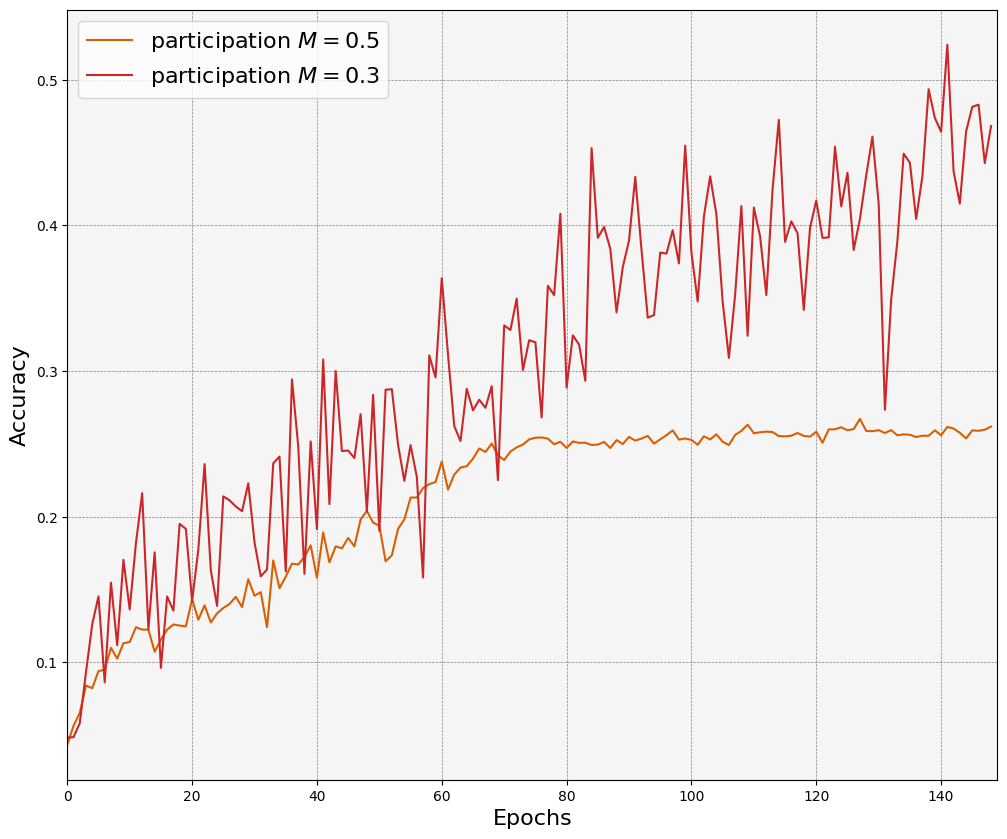

In [219]:
colab_5_global_acc = global_accuracies_dict_gen(colab_5.global_accuracies_dict, True)[:149]
participation_30_global_acc = np.mean(participation_30.global_accuracies, axis=1)[:149]
fig , ax = plt.subplots(figsize=(12, 10))
ax.set_facecolor((0.96, 0.96, 0.96))
ax.grid(True, color='gray', linestyle='dashed', linewidth=0.5)
ax.plot(colab_5_global_acc, label=r"participation $M=0.5$", color=colors["orange"])
ax.plot(participation_30_global_acc, label=r"participation $M=0.3$", color=colors["red"])
ax.set_xlabel("Epochs", fontsize=16)
ax.set_ylabel("Accuracy", fontsize=16)
ax.set_xlim(0, 149)
ax.legend(fontsize=16)

### Loss

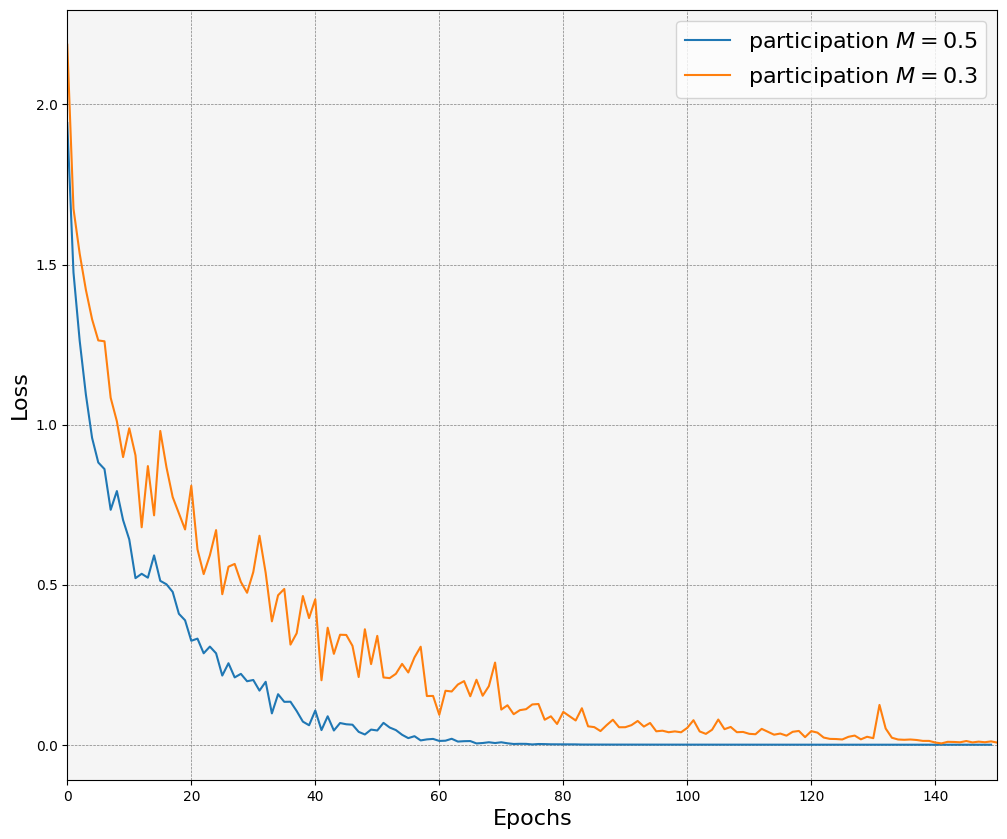

In [220]:
fig , ax = plt.subplots(figsize=(12, 10))
ax.set_facecolor((0.96, 0.96, 0.96))
ax.grid(True, color='gray', linestyle='dashed', linewidth=0.5)
ax.plot(get_average_loss(colab_5), label=r"participation $M=0.5$",)
ax.plot(get_average_loss(participation_30), label=r"participation $M=0.3$",)
ax.set_xlabel("Epochs", fontsize=16)
ax.set_ylabel("Loss", fontsize=16)
ax.set_xlim(0, 150)
ax.legend(fontsize=16)
plt.show()

Federated Multi-task learning in low-resource domains

## Dropout Sequential

In [221]:
nodropout = copy.deepcopy(Ordered_1localepoch_10server_epochs_at_each_global_round_lr__0_00001_server_avg__30_participation_SeqFL_pkl)
withdropout = copy.deepcopy(Ordered_1localepoch_10server_epochs_at_each_global_round_lr__0_00001_server_avg__30_participation_SeqFL_dropout_layer_pkl)

### Accuracy

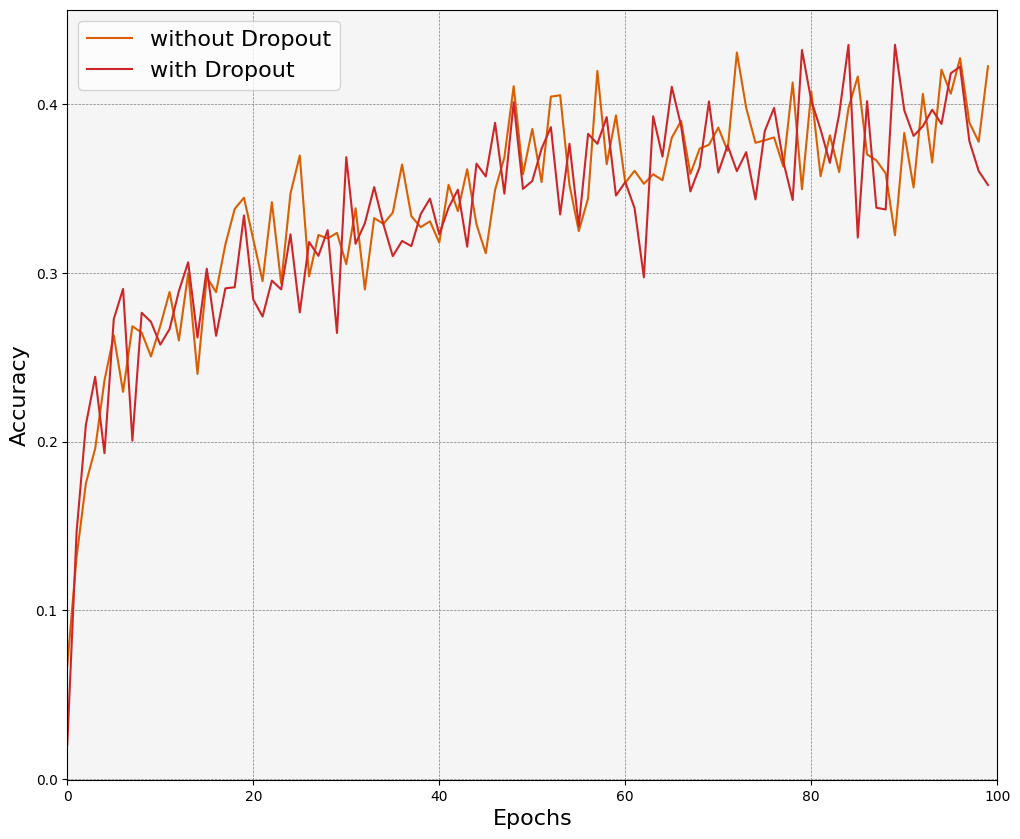

In [222]:
nodropout_global_acc =  get_average_global_accuracy_with_no_dict(nodropout)[:100]
withdropout_global_acc = get_average_global_accuracy_with_no_dict(withdropout)[:100]
fig , ax = plt.subplots(figsize=(12, 10))
ax.set_facecolor((0.96, 0.96, 0.96))
ax.grid(True, color='gray', linestyle='dashed', linewidth=0.5)
ax.plot(nodropout_global_acc, label=r"without Dropout", color=colors["orange"])
ax.plot(withdropout_global_acc, label=r"with Dropout", color=colors["red"])
ax.set_xlabel("Epochs", fontsize=16)
ax.set_ylabel("Accuracy", fontsize=16)
ax.set_xlim(0, 100)
ax.legend(fontsize=16)

### Loss

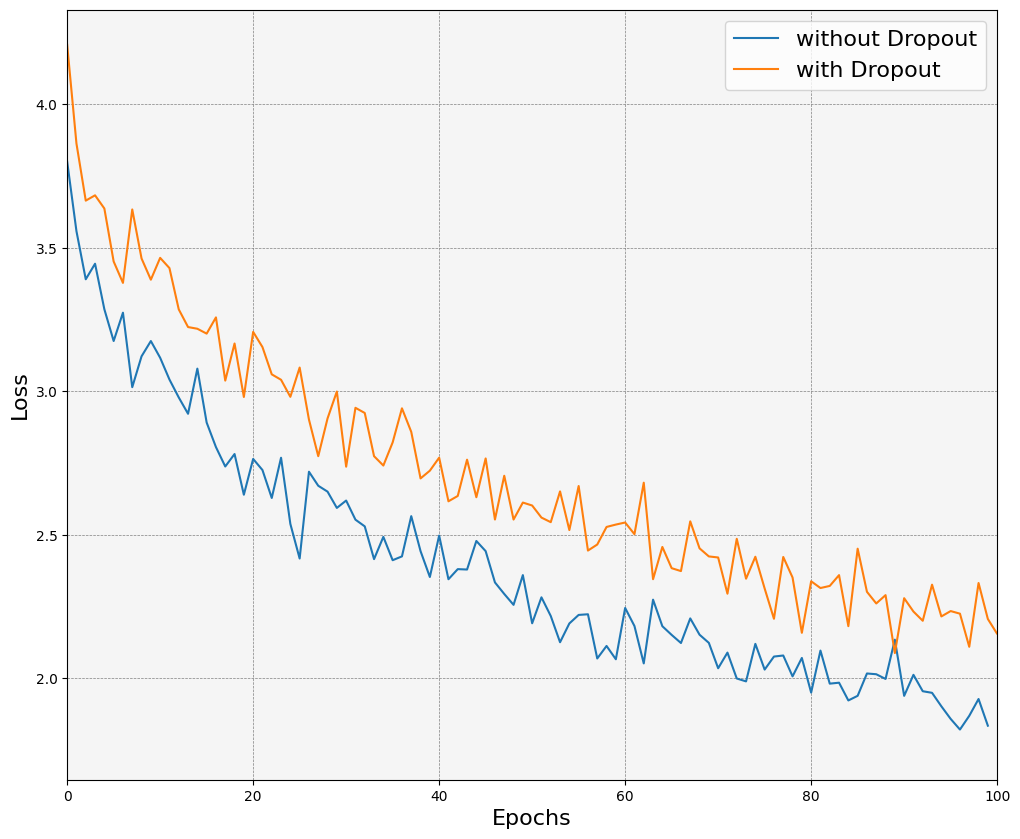

In [223]:
nodropout_loss = get_average_loss(nodropout)
withdropout_loss = get_average_loss(withdropout)
fig , ax = plt.subplots(figsize=(12, 10))
ax.set_facecolor((0.96, 0.96, 0.96))
ax.grid(True, color='gray', linestyle='dashed', linewidth=0.5)
ax.plot(nodropout_loss, label=r"without Dropout")
ax.plot(withdropout_loss, label=r"with Dropout")
ax.set_xlabel("Epochs", fontsize=16)
ax.set_ylabel("Loss", fontsize=16)
ax.set_xlim(0, min(len(nodropout_loss), len(withdropout_loss)))
ax.legend(fontsize=16)
plt.show()

## 30% vs 50% in particiation between 5 Local epochs 10 server, lr 0.00001

In [224]:
participation_30_5local = copy.deepcopy(ordered_5local_10server_0_00001_30partiipation)
sahar_50participation = copy.deepcopy(ordered_5local_10server_lr_0_00001_50participation)

### Accuracy

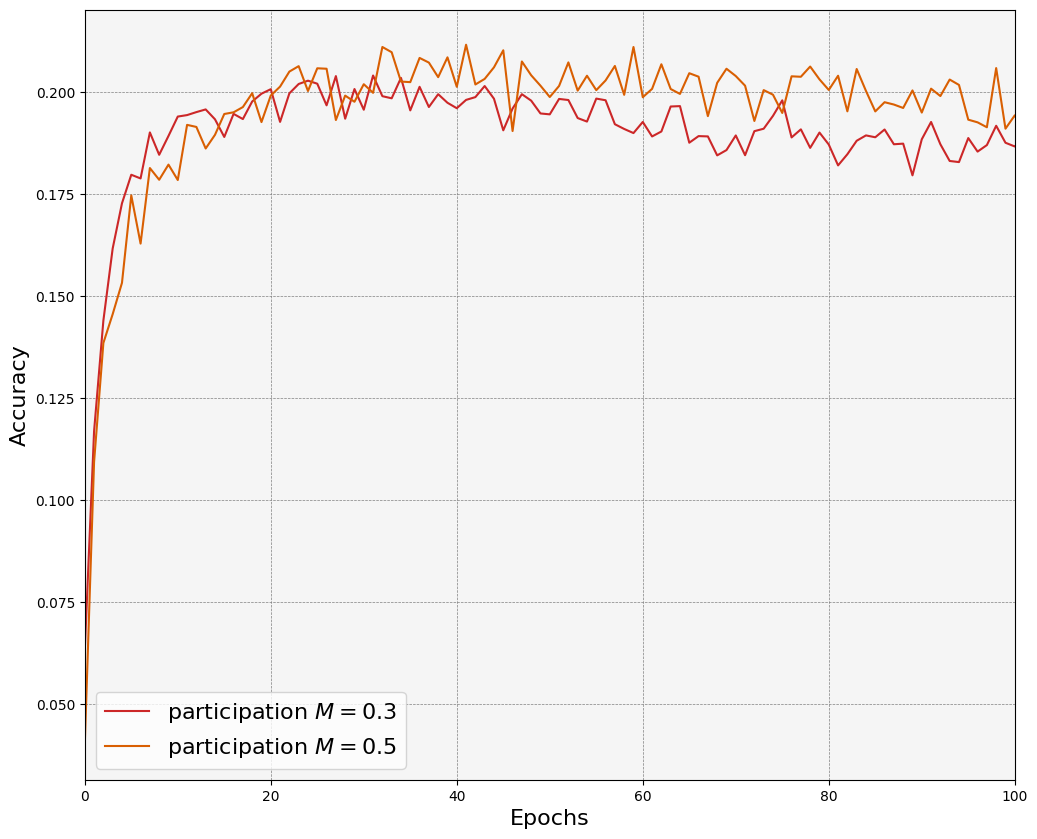

In [225]:
participation_30_5local_global_acc =  get_average_global_accuracy_with_no_dict(participation_30_5local)
sahar_50participation_global_acc = get_average_global_accuracy_with_no_dict(sahar_50participation)
fig , ax = plt.subplots(figsize=(12, 10))
ax.set_facecolor((0.96, 0.96, 0.96))
ax.grid(True, color='gray', linestyle='dashed', linewidth=0.5)
ax.plot(sahar_50participation_global_acc, label=r"participation $M=0.3$", color=colors["red"])
ax.plot(participation_30_5local_global_acc, label=r"participation $M=0.5$", color=colors["orange"])
ax.set_xlabel("Epochs", fontsize=16)
ax.set_ylabel("Accuracy", fontsize=16)
ax.set_xlim(0, 100)
ax.legend(fontsize=16)

### Loss

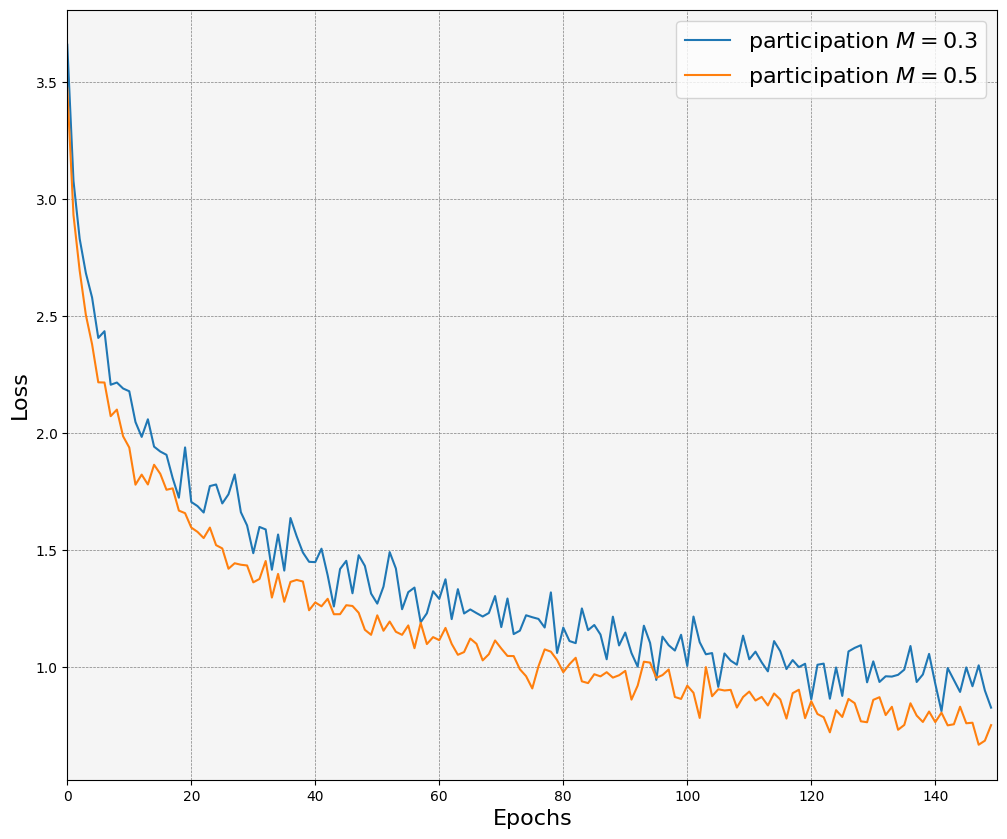

In [227]:
participation_30_5local_loss = get_average_loss(participation_30_5local)
sahar_50participation_loss = get_average_loss(sahar_50participation)
fig , ax = plt.subplots(figsize=(12, 10))
ax.set_facecolor((0.96, 0.96, 0.96))
ax.grid(True, color='gray', linestyle='dashed', linewidth=0.5)
ax.plot(participation_30_5local_loss, label=r"participation $M=0.3$")
ax.plot(sahar_50participation_loss, label=r"participation $M=0.5$")
ax.set_xlabel("Epochs", fontsize=16)
ax.set_ylabel("Loss", fontsize=16)
ax.set_xlim(0, min(len(participation_30_5local_loss), len(sahar_50participation_loss)))
ax.legend(fontsize=16)
plt.show()

# Clustered

## Number of datasets

In [231]:
nopath = copy.deepcopy(nopathmnist_Localepochs5_server_10_participation_30reordering_decreasinglronce_lrafter00001)
oct_and_organa = copy.deepcopy(oct_organa_ocalepochs5_server_10_par30_reordering_decreasinglronce_lrafter00001)
all_datasets = copy.deepcopy(ordered_5local_10server_0_00001_30partiipation)

### Accuracy

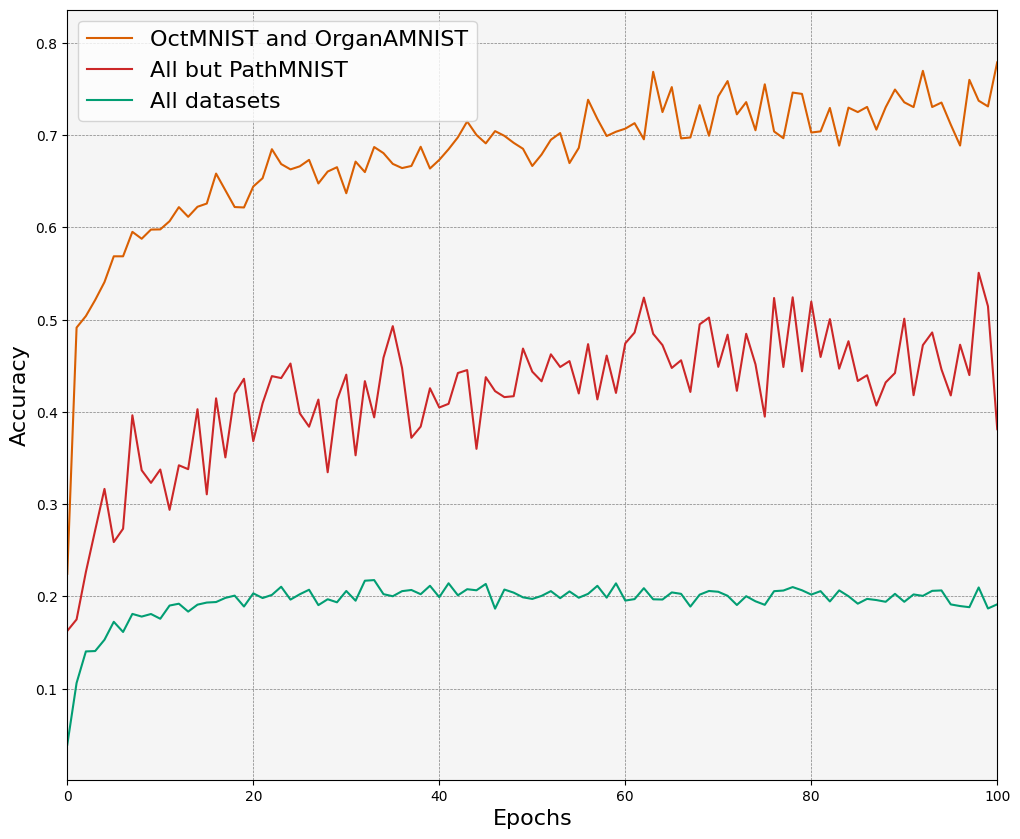

In [254]:
nopath_local_global_acc =  get_average_global_accuracy_with_no_dict(nopath)
oct_and_organa_global_acc = get_average_global_accuracy_with_no_dict(oct_and_organa)
all_datasets_global_acc = get_average_global_accuracy_with_no_dict(all_datasets)
fig , ax = plt.subplots(figsize=(12, 10))
ax.set_facecolor((0.96, 0.96, 0.96))
ax.grid(True, color='gray', linestyle='dashed', linewidth=0.5)
ax.plot(oct_and_organa_global_acc, label=r"OctMNIST and OrganAMNIST", color=colors["orange"])
ax.plot(nopath_local_global_acc, label=r"All but PathMNIST", color=colors["red"])
ax.plot(hamza_global_acc, label=r"All datasets", color=colors["green"])
ax.set_xlabel("Epochs", fontsize=16)
ax.set_ylabel("Accuracy", fontsize=16)
ax.set_xlim(0, 100)
ax.legend(fontsize=16)

### Loss

In [238]:
nopath
oct_and_organa
all_datasets

In [242]:
def get_average_loss_others(si):
    return si.clients_average_losses
print(get_average_loss_others(nopath))
print(get_average_loss_others(oct_and_organa))
print(get_average_loss_others(all_datasets))

{0: [3.8921413882025355, 3.952230114772402, 2.8850171122057686, nan, nan, 2.7718421919592497, 2.7112619400024416, nan, nan, nan, nan, nan, nan, 2.452752235840107, nan, nan, nan, nan, nan, nan, 2.2808933619795173, nan, nan, nan, 2.197043844749188, nan, nan, 2.1411714989563513, 2.1241896308701613, nan, nan, nan, nan, 2.0473570050864383, nan, 2.0280241185221177, 1.997564725218148, nan, 1.9604700055615656, 1.9473163781494929, 1.8908254487761136, nan, 1.9001660614178097, nan, 1.8402024869261118, nan, 1.8858238627170694, nan, 1.8277582600198943, 1.8089341508931127, nan, nan, nan, 1.7688191154907489, nan, nan, 1.724267569492603, 1.7211015097026168, 1.7026635659152063, nan, 1.6905835920366747, nan, nan, 1.6748269927912744, 1.6521233636757424, 1.6350121267910662, nan, nan, nan, nan, nan, 1.5704883970063308, nan, nan, nan, 1.5646791174493988, nan, nan, nan, 1.5574764601115523, nan, nan, nan, nan, nan, 1.4980400295093141, 1.489408775855755, 1.4717319069237544, nan, nan, nan, nan, nan, nan, nan, n

In [ ]:
='gray', linestyle='dashed', linewidth=0.5)
ax.plot(oct_and_organa_global_acc, label=r"OctMNIST and OrganAMNIST", color=colors["orange"])
ax.plot(nopath_local_global_acc, label=r"All but PathMNIST", color=colors["red"])
ax.plot(hamza_global_acc, label=r"All datasets", color=colors["green"]

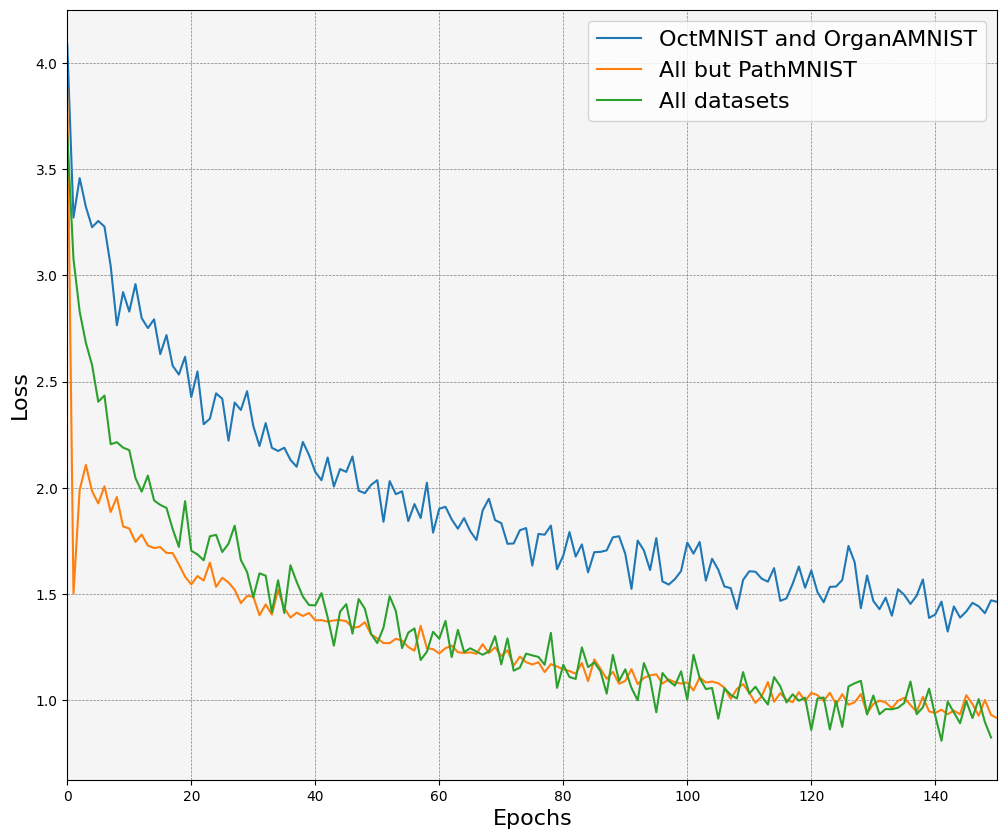

In [256]:
nopath_loss = nopath.get_average("loss")
oct_and_organa_loss = oct_and_organa.get_average("loss")
all_datasets_loss = all_datasets.get_average("loss")
fig , ax = plt.subplots(figsize=(12, 10))
ax.set_facecolor((0.96, 0.96, 0.96))
ax.grid(True, color='gray', linestyle='dashed', linewidth=0.5)
ax.plot(nopath_loss, label=r"OctMNIST and OrganAMNIST")
ax.plot(oct_and_organa_loss, label=r"All but PathMNIST")
ax.plot(get_average_loss(hamza), label=r"All datasets")
ax.set_xlabel("Epochs", fontsize=16)
ax.set_ylabel("Loss", fontsize=16)
ax.set_xlim(0, min(len(participation_30_5local_loss), len(sahar_50participation_loss)))
ax.legend(fontsize=16)
plt.show()